
# Master Thesis Presentation Notebook
## by Théo Stassen

This notebook presents the test protocol implemented for the purpose of the Master Thesis. 
The goal is the comparison of different probabilistic forecasting models and techniques, mainly from the deep learning field, 
in the context of the prediction of wind turbines production.

The code uses GluonTS, a toolkit which contains components and tools for building time series models using MXNet

Concerning the installation, to run of the code, are need to be installed 
(see https://gluon-ts.mxnet.io/install.html) :

- mxnet, using pip, in a compatible version with gluon ts (>=1.3.1,< 1.5.*, cpu only or with gpu support)  
- If you want gpu support, you need a compatible Nvidia gpu, and a compatible version (8.0, 9.0, or 9.2) of 
CUDA (and check after installation if working properly)
- gluonts, using pip

In [23]:
# Third party imports
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import scipy
import dataset as dt # Custom file containing class definition of Dataset

# In case of this error : 
# OSError: libcudart.so.9.2: cannot open shared object file: No such file or directory 
# if you are on (ubuntu) linux, do : sudo ldconfig /usr/local/cuda/lib64

## Dataset Import

The project need some input data. In this version, the input files are in /datasets.
They are array of values. GluonTS needs, to create datasets, some information .
   In general, the datasets defined by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version 
of the train dataset that contains a window in the end of each time series that was not seen during training. 
This window has length equal to the prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, the context (training) length
a prediction length, associated features (if we want to combine the temporal series information with other data), etc.


  All the models will use the data by splitting the time series (with a method that we can precise) into pieces of size 
  learning ("context") + predict length, on which they will train and predict.
  
  In this first version, only one array is imported and all the time series corresponds to the same source. 
  Precisely, we import the `6months-minutes.csv` file. The first idea was to use it as a single time serie, but
  unfortunately it implied very long training time, about 120s per epochs (100 epochs recommended). The data was correctly 
  splitted but Mxnet is not optimised for this situation. The solution is to split manually the 6 month into 
  different time series. The natural choice is to split into days. We have so 183 samples/time series of length 1440 time steps
  with a frequency of 1 minute. Each value is also divided by 1000 because it was causing loss problems without that.
  In future version we could import and combine the data of multiple sources as a single training/testing dataset, 
  or use multiple sources for training and one another for testing, as
  it is asked.
  We can also make other split size than 1 day. The "batch" size will be easily defined as
   an hyper parameter. The global hyper parameters
  are not already tested.
  
  The goal is to predict the production in a window of 10 minutes, which means 10 time steps.
  

In [24]:
df = pd.read_csv("datasets/6months-minutes.csv")
imported_dataset = np.array([df['Active Power'].to_numpy()])
n_sample = 183
imported_dataset = imported_dataset.reshape(n_sample, -1)  # Split by days
imported_dataset = imported_dataset / 1000
prediction_length = 10
context_length = 60 * 1  
freq = "1min"
start = pd.Timestamp("01-04-2019", freq=freq)
dataset = dt.Dataset(custom_dataset=imported_dataset, start=start, freq=freq,
                     prediction_length=prediction_length,
                     learning_length=context_length)

## Quantiles

In this project, the subject is the probabilistic forecasting of wind turbines time series but the goal is not really
to minimize the difference (in any ways to consider it) between the predicted values and the observed values.
The goal is to obtain a distribution of probability of the future values which have the more correct "safety" quantile
window (the space between the upper "security" quantile and the lower "security" quantile) . 
We want a model which tells us that there are 99% (or another security value) chance that the real value of production 
will be in this window and that affirmation must be exact, or at least the windows size must be overestimate, not
underestimate.
But the goal is also to obtain the thinner estimation window. 
We want a balance between not underestimate the safety window and the "precision" of the predict.

The quantile list contains the values of quantiles that are useful for us, and on which
the models that needs it will use. We want a 99% security probability so we consider the 
[0.005, 0.995] window and we compute also the 90% and 50% precision to have a gradual comparison.

In [25]:
quantiles = list([0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995])

## Metrics

To observe if the models performs well, to observe their quality considering the goals that are fixed, we 
need to choose the appropriate metrics. GluonTS proposes some metrics to evaluate models (MSE, MSIS, etc).

Concerning the correctness of the quantiles, none of the GluonTS metric is satisfying for this purpose. The proposed 
metric, "Coverage" is a simple combination of two of them. For a security limit of k :  

$Coverage = (k - coverage(k)) - (coverage(1-k) - (1-k)) $

With coverage(x), a GluonTS implemented metric which give the observed probability to have an value below the quantile x.
If the distribution is perfect the coverage of x must tends to the value x. For the upper quantile of the window,
 if coverage(x) > x, the quantile is too high (the window is too large) and
if coverage(x) < x the quantile is too low. And it is the opposite for the lower quantile.
For a 99% precision the security limit is 0.995. 

$Coverage = (0.995 - coverage(0.995)) - (coverage(0.005) - 0.005) $

To observe if the distribution is large, we compute a custom metric which is simply the mean of the difference between 
the quantile(k) and quantile(1-k). For a time serie :

$$Bandwidth = \frac{1}{p}  \sum_{i=0}^{p-1} quantile_{i}(k) - quantile_{i}(1-k) $$

Where p is the number of time step and $quantile_{i}$ the value of the quantile at time step i


In [26]:
chosen_metric = "Coverage"

## Custom loss

As explained in the previous sections, we want the model to give precise estimation of the quantiles.
The different models presented in the following sections will give more or less good results but we can interrogate how 
the model consider that it is itself good and if we want to modify this.
In most of the models, the loss function is the inverse of the log-density of the output distribution.
If $ \mu $ and $ \sigma $ are the parameters of the distribution output (in the case of a gaussian) of the model : 

$$ base\_loss(x) = - ln \varphi_{\mu,\sigma^2}(x)  $$

This loss is the natural way to formulate that we want that the distribution corresponds to the observed x.
But with this loss, the variation of the loss is inversely proportional to the deviation between x and the median
of the distribution (the "center", where the loss is minimal). 
For example if x1 at the position of the quantile(0.9) and if x2 is at 
quantile(0.99), loss(x1) is more or less the same than loss(x2).
We need another loss with the particular goal to discourage the values of x bigger than quantile(0.99) and lower than 
quantile(0.01). 
The proposed loss is the following (we can modify obviously the security limit):

$$ alt\_loss(x) = e^{x - quantile(0.995)} + e^{quantile(0.005)-x}$$

The loss increase exponentially if x is outside the security window, and is low if x is in the window.

In the pre-implemented GluonTs models the only usable loss is $base\_loss$ but if we create custom models 
it is possible to modify it. 
At this time, three custom models (one original, "Simple", and the copy of the pre-implemented "SimpleFeedForward" and 
"CanonicalRNN") are implemented. Others will come (but some of the models will be difficult to 
 modify, see MQCNN and MQRNN for example). And they uses this loss :

$$ custom\_loss = base\_loss + \alpha * alt\_loss $$

With $\alpha$ a parameter that we will make vary when comparing all the models together.
Depending of it value the results will be very different.

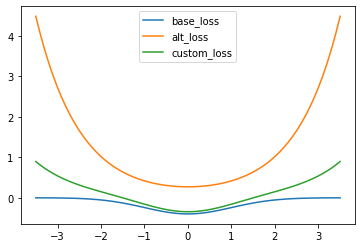

In [27]:
# Example to show the shape of the custom loss, 
# here with security quantiles -2 and 2. The value of x is relative to the position of the distribution median
x_values = np.arange(-3.5, 3.51, 0.1)
y_values = scipy.stats.norm(0, 1)
base_loss = -y_values.pdf(x_values)
alt_loss = [math.exp(x-2) + math.exp((-2 - x)) for x in x_values]
custom_loss = base_loss + [x*0.2 for x in alt_loss]
plt.plot(x_values, base_loss)
plt.plot(x_values, alt_loss)
plt.plot(x_values, custom_loss)
plt.legend(["base_loss", "alt_loss", "custom_loss"])
plt.show()

alphas = [0, 0.7, 0.8, 0.9]
alpha = 0.9

## Distribution

GluonTs proposes different type of output distribution. In most of the models the output is technically
 a vector of values which is
transformed to a vector of distribution parameters and put in a distribution object.
We can precise what kind of distribution.
Three of them are working for now. Gaussian, Laplace and PiecewiseLinear.
Also implemented but not used there are also Student, but it is rejected because we cannot obtain directly the quantiles of the distribution, 
that we need for the loss, and Uniform but it make the loss problematic.
And there are others, more complicated, like the multiple kernel gaussian.

In [28]:
distributions = ["Gaussian", "Laplace", "PiecewiseLinear" ]
distribution = "Gaussian"

# Different models

The organisation of the code is (important only) :

- 'main.py' equivalent of this notebook
- 'comparison.py' all the comparison of models
- 'forecast.py' the concrete forecasting part, for all type of models
- 'plots' all the possible plots
- '/agg_metrics' all the global metrics, saved in .txt files
- '/item_metrics' all the metrics per time series, saved in .npy files
- '/plots' all plot figures, saved in .png
- '/datasets' all the input datasets, not in the github for confidency reasons
- '/custom_models' all the custom models

All the pre-implemented deep learning models are presented here.
 In each section we compare the effects of the main parameters on the
coverage and bandwidth.
There are some global hyper parameters that are not tested here. 
The size of batch, the learning rate, 
the number of batches per epochs, the context length.
The different models have in general their hyper parameters on which simple comparison is done.

In [29]:
from comparison import compare_all_models, compare_simple, compare_simple_feed_forward, compare_canonicalrnn, \
    compare_deepar, compare_deepfactor, compare_mqcnn, compare_mqrnn

## Example of resulting plots

We can see what some of the models give as forecast results.
You can modify the number of epochs. 100 is the recommended number in many cases. 
It is normal that the coverage and bandwidth gives more than the 3 computed results, they use all the saved results.
I need to fix the visual. The others comparisons are more clear

In [ ]:
#Compare different models
epochs = 10
compare_all_models(dataset,["Gaussian"],[0,0.9],["cSimple", "cSimpleFeedForward","cCanonicalRNN"],chosen_metric,epochs,True)

In [ ]:
#Compare different alpha
compare_all_models(dataset,["Gaussian"],[0.5,10],["cSimple"],chosen_metric,epochs,True)

## Simple

A model which uses a simple 2 fully connected layers neural network.
The tunable parameter is the number of cells in layers

In [ ]:
num_cells = [10, 50, 100, 200, 300]
compare_simple(dataset, distribution, alpha, chosen_metric, epochs, num_cells)

## FeedForward

A simple MLP model.
The tunable parameter is the number of hidden nodes in each layer.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.89it/s, avg_epoch_loss=3.88e+22]
INFO:root:Epoch[0] Elapsed time 1.180 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=38824129209185121337344.000000
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 89.62it/s, avg_epoch_loss=1.52e+18]
INFO:root:Epoch[1] Elapsed time 1.117 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1516308373552612608.000000
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 92.73it/s, avg_epoch_loss=6.82e+14]
INFO:root:Epoch[2] Elapsed time 1.080 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=681700216225474.000000
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 93.75it/s, avg_epoch_loss=7.28e+12]
INFO:root:Epoch[3] Elapsed time 1.073 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7278469017198.482422
INFO:root:Epoch

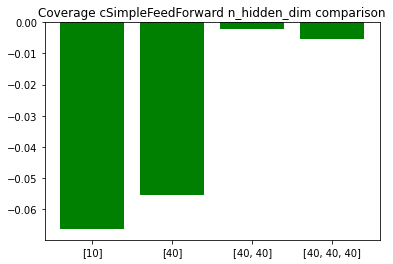

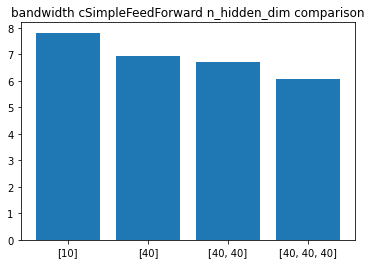

In [30]:
num_hidden_dimensions = [[10], [40], [40, 40], [40, 40, 40]]
compare_simple_feed_forward(dataset, distribution, alpha, chosen_metric, epochs, num_hidden_dimensions)

## Recurrent Neural Network

A model which uses a recurrent neural network.
The tunable parameters are the number of layers and number of cells of the network

In [ ]:
# Other parameters : num_cells and embedding dimensions
num_layers = [1, 2, 5, 10]
num_cells = [20,50,100]
compare_canonicalrnn(dataset, distribution, alpha, chosen_metric, epochs, "n_layers", num_layers)
compare_canonicalrnn(dataset, distribution, alpha, chosen_metric, epochs, "n_cells", num_cells)

## Deep Ar

Implementation of DeepAr estimator, a RNN based model, close to the one described in paper 
["DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks" ](https://arxiv.org/abs/1704.04110)
The tunable parameters are the same that for CanonicalRNN

In [ ]:
num_layers = [1, 2, 5, 10]
num_cells = [20,40,50,100]
compare_deepar(dataset,distribution,alpha,chosen_metric,epochs,"n_layers",num_layers)
compare_deepar(dataset,distribution,alpha,chosen_metric,epochs,"n_cells",num_cells)

## Deep Factors

Implementation of the 2019 ICML paper [“Deep Factors for Forecasting”](https://arxiv.org/abs/1905.12417)
It uses a global RNN model to learn patterns across multiple related time series and an arbitrary local model to model the time series on a per time series basis. 
In the current implementation, the local model is a RNN (DF-RNN).
The tunable parameters are the number of units per hidden layers and the number of layers in the global model
, the number of global factors. We could also add the number of units and layers in the local model.

In [ ]:
num_hidden_global = [20,50,100]
num_layers_global = [1, 2, 5]
num_factors = [5, 10, 20]
compare_deepfactor(dataset,distribution,alpha,chosen_metric,epochs,"n_hidden_global",num_hidden_global)
compare_deepfactor(dataset,distribution,alpha,chosen_metric,epochs,"n_layers_global",num_layers_global)
compare_deepfactor(dataset,distribution,alpha,chosen_metric,epochs,"n_factors",num_factors)

## Gaussian Process

Model using Gaussian Processes (GP).
Each time series has a GP.
There are no parameters easy to tune

## NPTS

Implementation of the Non-Parametric Time Series Forecaster, 
which falls into the class of simple forecasters that use one of the past observed targets as the forecast for 
the current time step. It randomly samples a past time index as the prediction for the time step T (it is 
an auto regressive model which predict time steps one by one). 
There are no parameters to tune, but some variant are possible.


## MQCNN

Discriminative Sequence to Sequence model made using the SeqtoSeq framework of GluonTS to reproduce the model of the 
paper [A Multi-Horizon Quantile Recurrent Forecaster](https://arxiv.org/abs/1711.11053).
Sequence to sequence models are composed of two parts. The encoder network, that reads in a certain context of the training range of the time series 
and encodes information about  the  sequence  in  a  latent  state.
And the decoder network, which generates the forecast by combining the latent information with the features in the prediction range
In MQCNN the encoder is a Convolutionnal Neural Network and the decoder an mlp model. The output
is not technically a  distribution but the quantiles itself, that are predicted values obtain by optimizing
the corresponding quantile loss (In general in a deterministic world if you train a model with as loss the quantile
loss [0.9], you will obtain the line representing the quantile [0.9])
The tunable parameter is the  dimension of the mlp decoder.
A problem with the seqtoseq models is that we cannot use directly the custom loss. A investigation is 
needed on how do the same kind of modification of the loss.

In [ ]:
mlp_final_dim = [10,20,30]
compare_mqcnn(dataset, distribution, alpha, chosen_metric, epochs, mlp_final_dim)

## MQRNN

Same as MQCNN but with a Recurrent Neural Network encoder.

In [ ]:
mlp_final_dim = [10,20,30]
compare_mqrnn(dataset, distribution, alpha, chosen_metric, epochs, mlp_final_dim)

## Global comparison

Here is the comparison of all models, for different alphas and distribution output type
 with all the presented models in addition of two models not using deep learning
(the R package that allows in GluonTS to use non-deep learning well known models, here ETS, and seasonal naive).

In [ ]:
models = ["cSimple", "cSimpleFeedForward", "cCanonicalRNN", "DeepAr", "DeepFactor", "GaussianProcess", "NPTS", "MQCNN", "MQRNN", "R", "SeasonalNaive"]
compare_all_models(dataset, distributions, alphas, models, chosen_metric, epochs,False)
 

# Other plots implemented

## metrics by time series

We can obtain the item metrics, i.e. the metrics for each time series instead of the global metrics for all time
series. These metrics can be plot as histogram of metric values, to see the repartition of values in the 183 time
series. This not works  for all metrics, for coverage the results are not precise. An example is the MSE for the 
three first models. 

In [ ]:
from plots import plot_distr_params, hist_plot_item_metrics
compare_all_models(dataset, ["Gaussian"], [0.9], ["cSimple", "cSimpleFeedForward","cCanonicalRNN"], "MSE", epochs,False)
hist_plot_item_metrics("MSE", ["cSimple", "cSimpleFeedForward","cCanonicalRNN"], )  

## distribution information
Not working for an unknown reason. 

In the custom models we save the exact parameters of output distribution. We can plot the values here. 
For the SeqtoSeq models, the quantiles are directly saved. And not plotted.

In [ ]:
plot_distr_params(["cSimple", "cSimpleFeedForward","cCanonicalRNN"], [0], distributions) 
